### Imports and configuration

In [1]:
# setup variables

import os
import json
import tqdm
from s2orc.config import CURRENT_VERSION

# jsonlines https://jsonlines.readthedocs.io/en/latest/#api
import jsonlines
import gzip
import numpy as np
import matplotlib.pyplot as plt
import hiplot # <3

LOCAL_S2ORC_DIR = 's2orc-data'

psychology_paper_dir = os.path.join(LOCAL_S2ORC_DIR, CURRENT_VERSION, 'psychology')
psychology_paper_suffix = 'psych.text.jsonl'

links_dir = os.path.join(LOCAL_S2ORC_DIR, CURRENT_VERSION, 'psych_links')
links_suffix = 'psych.text.link.jsonl'

## let's do it! <3

In [2]:
import pprint

start = 0
span = 1 # all: 1700

links_files = sorted(os.listdir(links_dir), key=lambda f: int(f.split('.')[0]))[start:(start+span)]
for link_file in tqdm.tqdm(links_files):
    with gzip.open(os.path.join(links_dir, link_file), 'rb') as f_in:
        links = list(jsonlines.Reader(f_in))
        for link in links:
            pp = pprint.PrettyPrinter(indent=1)
            pp.pprint(link['citing_paper']['metadata'])
            pp.pprint(link['citation_context'])
            pp.pprint(link['cited_paper']['metadata'])

100%|██████████| 1/1 [00:00<00:00, 14.69it/s]

{'abstract': None,
 'acl_id': None,
 'arxiv_id': None,
 'authors': [{'first': 'Anagha', 'last': 'Aery', 'middle': [], 'suffix': ''},
             {'first': 'Julie', 'last': 'Hodges', 'middle': [], 'suffix': ''},
             {'first': 'Jamin', 'last': 'Day', 'middle': ['J.'], 'suffix': ''}],
 'doi': '10.2991/uipsur-17.2018.50',
 'journal': 'Proceedings of the Universitas Indonesia International Psychology '
            'Symposium for Undergraduate Research (UIPSUR 2017)',
 'pmc_id': None,
 'pubmed_id': None,
 'title': 'The Effect of School-Based Stepping Stones Triple P on Child and '
          'Parent Outcomes',
 'venue': 'Proceedings of the Universitas Indonesia International Psychology '
          'Symposium for Undergraduate Research (UIPSUR 2017)',
 'year': '2018'}
{'cite_end': 345,
 'cite_start': 297,
 'cite_str': 'Roberts, Mazzucchelli, Studman, & Sanders, 2006;',
 'cited_paper_id': '2019870',
 'context_string': 'Roberts, Mazzucchelli, Studman, & Sanders, 2006;',
 'paper_id': '1

## Get corpus into memory

In [3]:
import pprint

start = 0
span = 1700 # all: 1700

links = []

links_files = sorted(os.listdir(links_dir), key=lambda f: int(f.split('.')[0]))[start:(start+span)]
for link_file in tqdm.tqdm(links_files):
    with gzip.open(os.path.join(links_dir, link_file), 'rb') as f_in:
        batch_links = list(jsonlines.Reader(f_in))
        for link in batch_links:
            if link['citing_paper']['grobid_parse'].get('body_text') is not None and link['cited_paper']['grobid_parse'].get('body_text') is not None:
                links.append(link)

np.random.seed(2134234)
links = np.array(links)
np.random.shuffle(links)

100%|██████████| 1500/1500 [01:00<00:00, 24.66it/s]


In [4]:
len(links)

2209

In [70]:
n_train_links = int(0.5 * len(links))
n_validation_links = int(0.2 * len(links))
n_test_links = len(links) - n_train_links - n_validation_links
train_links = links[:15]
#validation_links = links[n_train_links:n_train_links + n_validation_links]
#test_links = links[-n_test_links:]
links = None

In [40]:
from Vector_Similarity import *

2.23606797749979
0.9999999999999998
0.0004639582566999478


In [51]:
from scipy.spatial import distance

In [59]:
from scipy.linalg import norm

In [60]:
def TS_SS(vec1, vec2) :
    return Triangle(vec1, vec2) * Sector(vec1, vec2)

In [61]:
def Triangle(vec1, vec2) :
    theta = math.radians(Theta(vec1,vec2))
    return (norm(vec1) * norm(vec2) * math.sin(theta)) / 2

In [62]:
def Theta(vec1, vec2) :
    return math.acos(distance.cosine(vec1, vec2)) + math.radians(10)

In [63]:
def Magnitude_Difference(vec1, vec2) :
    return abs(norm(vec1) - norm(vec2))

In [64]:
def Sector(vec1, vec2) :
    ED = distance.euclidean(vec1, vec2)
    MD = Magnitude_Difference(vec1, vec2)
    theta = Theta(vec1, vec2)
    return math.pi * math.pow((ED+MD),2) * theta/360

## Do stuff

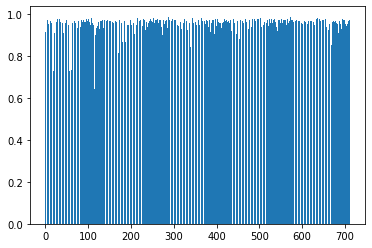

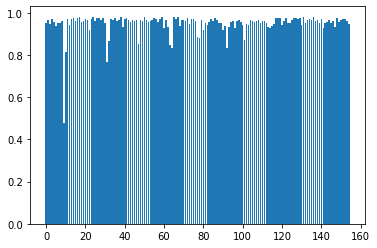

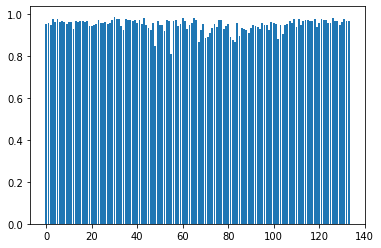

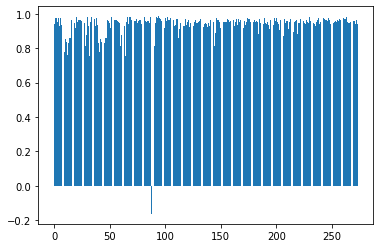

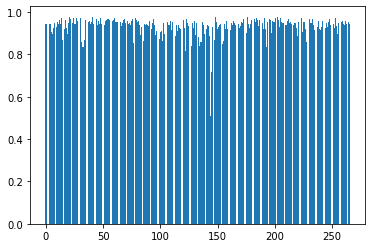

In [114]:
from syntok.segmenter import split
from syntok.tokenizer import Tokenizer
import json
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentPoolEmbeddings, StackedEmbeddings
from flair.data import Sentence
import numpy as np
import tqdm
import sys

glove_embedding = DocumentPoolEmbeddings([WordEmbeddings('glove')])

all_sim = {}
count = 0
start = 10
span = 5
# for link in tqdm.tqdm(train_links[start:start+span]):
for link in train_links[start:start+span]:
#     print('\nCITING PAPER')
    context = link['citation_context']
    citing_paper = link['citing_paper']
    cited_paper = link['cited_paper']
#     pp.pprint(citing_paper)
#     print('\nCITED PAPER')
    
#     pp.pprint(cited_paper)
    
    # find the adequate context pair
    glove_similarities = []
    citing_string = ''.join([context['pre_context'], context['context_string'], context['post_context']])
    s = Sentence(citing_string, use_tokenizer=True)
    glove_embedding.embed(s)
    glove_citation_embedding = s.embedding.detach()

    for paper_part, text_chunks in cited_paper['grobid_parse'].items():
        # make sure grobid_parse is fully ok
        if text_chunks is not None:
            for text_chunk in text_chunks:
                if isinstance(text_chunk, dict):
                    text = text_chunk.get('text')
                    tokenized_sents = list(split(Tokenizer().tokenize(text)))
                    sents = [' '.join(str(token) for token in sent) for sent in tokenized_sents]

                    sentences = [s for s in [Sentence(sent, use_tokenizer=True) for sent in sents] if len(s.tokens) > 0]
                    embeddings = glove_embedding.embed(sentences)
                    for s in sentences:
                        e1 = s.embedding.detach()
                        e2 = glove_citation_embedding
                        sim = 1-distance.cosine(e1, e2)
                        #sim = np.dot(e1, e2) / (np.sqrt(np.dot(e1, e1)) * np.sqrt(np.dot(e2, e2)))
                        glove_similarities.append((sim, s.to_original_text()))

#     print('\n\n\n--- PAPER ---', '\n', cited_paper['metadata']['title'], end='\n')
#     print('\n\ncontext: ', citing_string, end='\n\n')
#     print('\n\nsimilarities: ', end='\n\n')
#     print(*sorted(glove_similarities, key=lambda x: x[0], reverse=True)[:20], sep='\n\n')
    all_sim[citing_string] = glove_similarities
    just_sim = [sim for sim, text in glove_similarities]
    fig, ax = plt.subplots()
    #ax.hist(just_sim, bins=np.linspace(0, 1, 20))
    ax.bar(np.arange(0,len(just_sim)), just_sim)
    plt.savefig("report/sentence_"+str(count))
    count+=1
#             print('FLAIR')
#             print(*sorted(flair_similarities, key=lambda x: x[0], reverse=True)[:10], sep='\n\n')    

In [31]:
x = list(all_sim.keys())[0]
first = all_sim[x]
x

'Martinez-Trujillo & Treue, 2004; Zhou & Desimone, 2011) . Moreover, the operation of attention within perceptual systems can be distinguished in several ways from central attentional mechanisms that play a role in response selection, memory search, and so on (Pashler, 1994) . In the present study, we will focus on VWM, and we will focus on the role of spatial attention in the selective encoding of perceptual information into VWM. The relationship between attention and VWM maintenance will be addressed'

In [32]:
sorted_first = sorted(first, key = lambda x: x[0])
sorted_first.reverse()
sorted_first

[(0.988065779209137,
  ' Thus ,  although  driving  and  thinking  seem  to  represent  a  case  of  " simultaneous  performance "  and  therefore  a  challenge  to  the  bottleneck -oriented  perspective  advocated  here ,  the  lack  of  obvious  interference  may  simply  reflect  two  conclusions  already  reached :  ( a )  that  perceptual  monitoring  can  occur  at  the  same  time  as  central  processes  and  ( b )  that  central  processes  can  be  interrupted  quickly  on  the  basis  of  detections  made  in  the  course  of  monitoring  the  environment .'),
 (0.9856774806976318,
  ' For  this  reason ,  studies  that  have  varied  the  number  of  alternatives  in  choice  tasks  over  the  range  between  one  and  two  must  be  interpreted  with  great  caution  ( e.g . ,  Karlin  &  Kestenbaum ,  1968 ;  Schweickert ,  1978 )  ;  evidently ,  this  manipulation  does  not  simply  change  the  duration  of  a  particular  stage  or  insert  a  single  stage ,  as  D

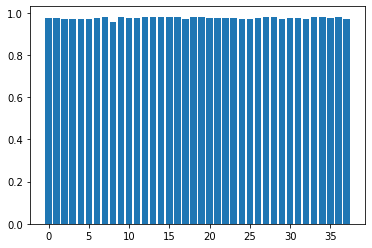

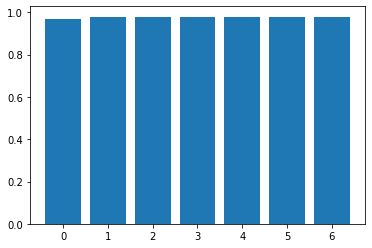

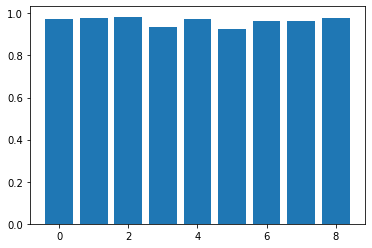

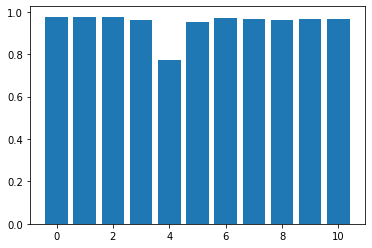

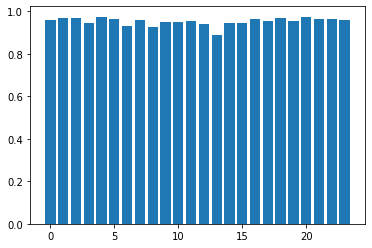

In [115]:
from syntok.segmenter import split
from syntok.tokenizer import Tokenizer
import json
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentPoolEmbeddings, StackedEmbeddings
from flair.data import Sentence
import numpy as np
import tqdm
import sys
from scipy.spatial import distance
import tensorflow as tf

glove_embedding = DocumentPoolEmbeddings([WordEmbeddings('glove')])

all_sim = {}
all_sim_ts_ss = {}

start = 10
span = 5
count = 0
# for link in tqdm.tqdm(train_links[start:start+span]):
for link in train_links[start:start+span]:
#     print('\nCITING PAPER')
    context = link['citation_context']
    citing_paper = link['citing_paper']
    cited_paper = link['cited_paper']
#     pp.pprint(citing_paper)
#     print('\nCITED PAPER')
    
#     pp.pprint(cited_paper)
    
    # find the adequate context pair
    glove_similarities = []
    glove_similarities_ts_ss = []
    citing_string = ''.join([context['pre_context'], context['context_string'], context['post_context']])
    s = Sentence(citing_string, use_tokenizer=True)
    glove_embedding.embed(s)
    glove_citation_embedding = s.embedding.detach()

    for paper_part, text_chunks in cited_paper['grobid_parse'].items():
        # make sure grobid_parse is fully ok
        if text_chunks is not None:
            for text_chunk in text_chunks:
                if isinstance(text_chunk, dict):
                    b = text_chunks
                    text = text_chunk.get('text')
                    #tokenized_sents = list(split(Tokenizer().tokenize(text)))
                    #sents = [' '.join(str(token) for token in sent) for sent in tokenized_sents]

                    #sentences = [s for s in [Sentence(sent, use_tokenizer=True) for sent in sents] if len(s.tokens) > 0]
                    #a = sentences[0]
                    #sentences = [' '.join(sentences[i:i+3]) for i in range(len(sentences)-3)]
                    sentence = Sentence(text)
                    glove_embedding.embed(sentence)
                    a = sentence
                    sim = 1 - distance.cosine(sentence.embedding.detach(), glove_citation_embedding)
                    sim_ts = 1 - TS_SS(sentence.embedding.detach(), 
                                       glove_citation_embedding)
                    glove_similarities.append((sim, sentence.to_original_text()))
                    glove_similarities_ts_ss.append((sim_ts, sentence.to_original_text()))

#     print('\n\n\n--- PAPER ---', '\n', cited_paper['metadata']['title'], end='\n')
#     print('\n\ncontext: ', citing_string, end='\n\n')
#     print('\n\nsimilarities: ', end='\n\n')
#     print(*sorted(glove_similarities, key=lambda x: x[0], reverse=True)[:20], sep='\n\n')
    all_sim[citing_string] = glove_similarities
    all_sim_ts_ss[citing_string] = glove_similarities_ts_ss
    just_sim = [sim for sim, text in glove_similarities]
    just_sim_ts_ss = [sim for sim, text in glove_similarities_ts_ss]
    fig, ax = plt.subplots()
    #ax.hist(just_sim, bins=np.linspace(0, 1, 20))
    ax.bar(np.arange(0,len(just_sim)), just_sim)
    plt.savefig("report/section_"+str(count))
    count+=1
    #ax.bar(np.arange(0,len(just_sim_ts_ss)), just_sim_ts_ss)
#             print('FLAIR')
#             print(*sorted(flair_similarities, key=lambda x: x[0], reverse=True)[:10], sep='\n\n')  

In [67]:
x = list(all_sim.keys())[0]
results = all_sim[x]
x

'Martinez-Trujillo & Treue, 2004; Zhou & Desimone, 2011) . Moreover, the operation of attention within perceptual systems can be distinguished in several ways from central attentional mechanisms that play a role in response selection, memory search, and so on (Pashler, 1994) . In the present study, we will focus on VWM, and we will focus on the role of spatial attention in the selective encoding of perceptual information into VWM. The relationship between attention and VWM maintenance will be addressed'

In [68]:
results_ts = all_sim_ts_ss[x]

In [39]:
sorted_first = sorted(results, key = lambda x: x[0])
sorted_first.reverse()
sorted_first

[(0.9814106225967407,
  'The pairs of tasks used in the investigations described thus far did not require difficult concurrent perceptual processing of stimuli in the same sensory modality. Concurrent perceptual processing has been extensively investigated in tasks such as visual search in which there is only one task (i.e., one response) per trial but many stimuli. This research has produced a large literature that cannot be reviewed here, but the main findings need to be related to the conclusions reached earlier. When perceptual tasks require difficult concurrent processing, accuracy often suffers. This has been most clearly demonstrated in visual search and dichotic monitoring tasks in which the subject sees or hears more than one stimulus but makes only a single response. In one particularly revealing experimental design, the subject makes a forced-choice judgment about which of two possible targets was present in a display (each item is followed by a mask). Performance is compare

In [69]:
sorted_first = sorted(results_ts, key = lambda x: x[0])
sorted_first.reverse()
sorted_first

[(0.9974859793535963,
  'This review suggests that a focus on relatively simple tasks reveals much about the underlying limitations on people\'s ability to perform different tasks at the same time. The results show that people have surprisingly severe limitations on their ability to carry out simultaneously certain cognitive processes that seem fairly trivial from a computational standpoint. On the other hand, it is clear that mental operations frequently overlap with each other, for example, people can readily monitor sensory input at the same time that they carry out unrelated central processes such as memory retrieval. Central processes can sometimes be aborted on the basis of the outcome of perceptual analyses. Future research could profitably extend these analyses "upward" and "downward." In the upward direction, much more remains to be learned about how the mechanisms apparent in simple tasks manifest themselves in more complex activities of comprehension, reasoning, and thought.

In [97]:
glove_embedding = DocumentPoolEmbeddings([WordEmbeddings('glove')])

def check_similarities(links, metrics, chunksize):
    all_sim = {}
    for link in links:
        context = link['citation_context']
        citing_paper = link['citing_paper']
        cited_paper = link['cited_paper']
        # find the adequate context pair
        citing_string = ''.join([context['pre_context'], context['context_string'], context['post_context']])
        s = Sentence(citing_string, use_tokenizer=True)
        glove_embedding.embed(s)
        glove_citation_embedding = s.embedding.detach()
        all_sim[citing_string] = {}
        for paper_part, text_chunks in cited_paper['grobid_parse'].items():
            # make sure grobid_parse is fully ok
            if text_chunks is not None:
                for text_chunk in text_chunks:
                    if isinstance(text_chunk, dict):
                        text = text_chunk.get('text')
                        tokenized_sents = list(split(Tokenizer().tokenize(text)))
                        sents = [' '.join(str(token) for token in sent) for sent in tokenized_sents]
                        sents = [' '.join(sents[i:i+chunksize]) for i in range(len(sents)-chunksize)]
                        sentences = [s for s in [Sentence(sent, use_tokenizer=True) for sent in sents]\
                                     if len(s.tokens) > 0]
                        glove_embedding.embed(sentences)
                        for sentence in sentences:
                            all_sim[citing_string][sentence.to_plain_string()] = {}
                            for name, metric in metrics.items():
                                sim = 1 - metric(sentence.embedding.detach(), glove_citation_embedding)
                                all_sim[citing_string][sentence.to_plain_string()][name] = sim
    return all_sim

In [98]:
metrics = {"cos" : distance.cosine, "ts_ss" : TS_SS}

In [121]:
all_sim = check_similarities(train_links[:3], metrics, chunksize=3)

In [131]:
keys = list(all_sim.keys())
len(keys)

3

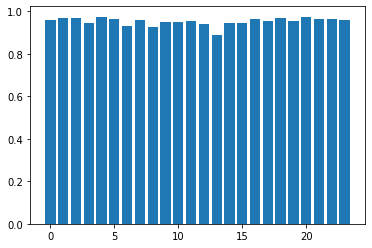

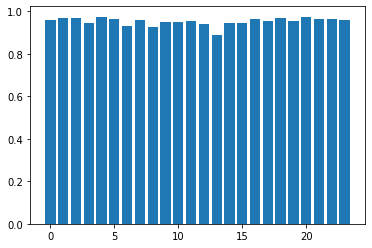

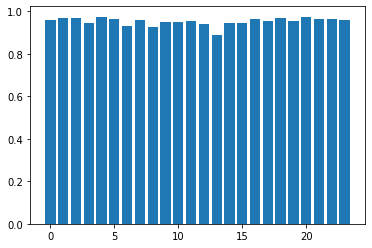

In [133]:
for i in range(3):
    a = all_sim[x]
    metrics = list(a.values())
    cos = [i["cos"] for i in metrics]
    fig, ax = plt.subplots()
    ax.bar(np.arange(0,len(just_sim)), just_sim)
    plt.savefig("report/figures/3_sent_"+str(i))

In [108]:
sorted_cos

[{'cos': 0.8804134130477905, 'ts_ss': 0.978538396336227},
 {'cos': 0.8812578916549683, 'ts_ss': 0.9774068594088886},
 {'cos': 0.8954041004180908, 'ts_ss': 0.9783558541703707},
 {'cos': 0.908331573009491, 'ts_ss': 0.9884030058332302},
 {'cos': 0.9170565009117126, 'ts_ss': 0.9922713239844718},
 {'cos': 0.9226295948028564, 'ts_ss': 0.9862528960712365},
 {'cos': 0.9228281378746033, 'ts_ss': 0.9848473671964294},
 {'cos': 0.9253838062286377, 'ts_ss': 0.9860755622467683},
 {'cos': 0.926733672618866, 'ts_ss': 0.9908810345354124},
 {'cos': 0.9271116256713867, 'ts_ss': 0.9904340555316982},
 {'cos': 0.9271557331085205, 'ts_ss': 0.9898748053699962},
 {'cos': 0.9281391501426697, 'ts_ss': 0.9905394425282364},
 {'cos': 0.9284370541572571, 'ts_ss': 0.988276416430638},
 {'cos': 0.9292514324188232, 'ts_ss': 0.9893618952384032},
 {'cos': 0.9293734431266785, 'ts_ss': 0.9895884031529443},
 {'cos': 0.9299887418746948, 'ts_ss': 0.9881505937951496},
 {'cos': 0.9301506280899048, 'ts_ss': 0.9851819890678479},
 